In [1]:
Mjj_selection = 1000.

vae_loss = 'mae'

SM_eff = 1e-2

def computeDiscriminatingVar(x):
    out = x[:,-2]/x[:,1]+x[:,-1]/x[:,6]
    out *= 1e5
    return out

# def computeDiscriminatingVar(x):
#     out = x[:,-2]+x[:,-1]
#     return out*1e4

# Imports

In [2]:
from __future__ import print_function

import h5py, os, sys, glob, datetime, time
sys.path.append('../lib')
from glob import glob
import numpy as np
import scipy as sp
from scipy.special import erf

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
from matplotlib.colors import LogNorm

from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
import joblib
from prettytable import PrettyTable

import ROOT as rt
rt.gErrorIgnoreLevel = rt.kError

from histo_utilities import create_TH2D, create_TH1D, create_Canvas, make_effiency_plot, rootTH1_to_np
from progressBar import ProgressBar

from cebefo_style import cebefo_style
cebefo_style()

dnd = []

Welcome to JupyROOT 6.16/00


# Get the discrimination on the side-band

['mJJ', 'j1Pt', 'j1Eta', 'j1Phi', 'j1M', 'j1E', 'j2Pt', 'j2M', 'j2E', 'DeltaEtaJJ', 'DeltaPhiJJ', 'j1Loss', 'j2Loss']
(38568, 13)


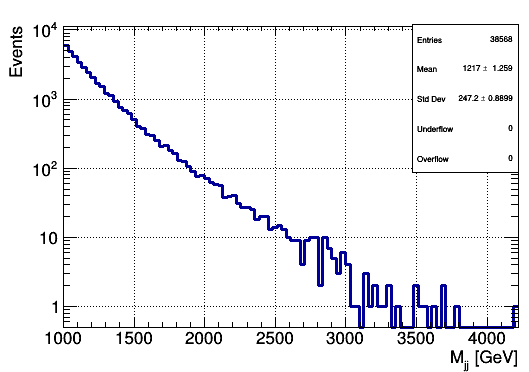

In [3]:
f = h5py.File('../data/vae_'+vae_loss+'/qcd_dEta_sideband_results.h5', 'r')
print(list(f.get("labels")))

data_side = np.array(f.get("results"))

# apply the dijet mass cut
data_side = data_side[data_side[:,0] > Mjj_selection]
print(data_side.shape)

c = create_Canvas(size=(int(800/1.5),int(600/1.5)))
h_Mjj_side = create_TH1D(data_side[:,0], title='', axis_title = ['M_{jj} [GeV]','Events'], 
                opt='overflow', 
                binning=[100, Mjj_selection, np.max(data_side[:,0])])

h_Mjj_side.Draw()
c.SetLogy()
c.Draw()

### Train the model to predict the cut

In [4]:
gbr_cut = GradientBoostingRegressor(loss='quantile', alpha=1-SM_eff,
                                n_estimators=250, max_depth=3,
                                learning_rate=.1, min_samples_leaf=5,
                                min_samples_split=5,
                                validation_fraction=0.5,
                                n_iter_no_change=5,
                                tol=1e-5,
                                verbose=2)

x = np.reshape(data_side[:,0], (-1,1))
y = computeDiscriminatingVar(data_side)
gbr_cut.fit(x, y);

date = datetime.date.today()
date_str = '{}{:02d}{:02d}'.format(date.year, date.month, date.day)
joblib.dump(gbr_cut, '../models/gbr_cut_trained_{}.joblib'.format(date_str)) 

      Iter       Train Loss   Remaining Time 
         1           0.3946            6.65s
         2           0.3940            4.94s
         3           0.3934            4.24s
         4           0.3929            3.54s
         5           0.3925            3.17s
         6           0.3922            2.88s
         7           0.3919            2.70s
         8           0.3915            2.55s
         9           0.3912            2.40s
        10           0.3910            2.33s
        11           0.3908            2.24s
        12           0.3907            2.18s
        13           0.3905            2.11s
        14           0.3904            2.06s
        15           0.3903            2.01s
        16           0.3902            1.96s
        17           0.3898            1.92s
        18           0.3894            1.89s
        19           0.3891            1.86s


['../models/gbr_cut_trained_20190801.joblib']

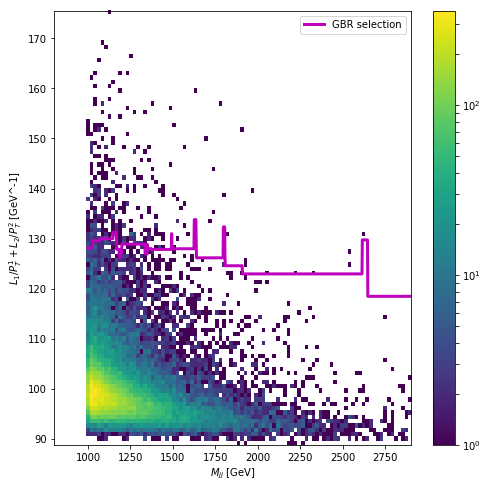

In [5]:
plt.figure(figsize=(8, 8))
x_min = Mjj_selection*0.8
x_max = np.quantile(x, 0.999)
plt.hist2d(x[:,0], y,
           range=((x_min , x_max), (np.min(y), np.quantile(y, 1-1e-4))), 
           norm=LogNorm(), bins=100,
           label='Side band data'
          )

xs = np.arange(Mjj_selection, x_max, 0.001*(x_max-Mjj_selection))
plt.plot(xs, gbr_cut.predict(np.reshape(xs, (-1,1))), '-', color='m', lw=3, label='GBR selection')

plt.ylabel('$L_1/P^1_T + L_2/P^2_T$ [GeV^-1]')
plt.xlabel('$M_{jj}$ [GeV]')
plt.colorbar()
plt.legend(loc='best')
plt.draw()

In [6]:
def getSelection(x_Mjj, x_loss):
    cut = gbr_cut.predict(np.reshape(x_Mjj, (-1,1)))
    return x_loss > cut

In [7]:
def plotMassSpectrum(mJJ_pass, mJJ_rej, title=''):
    h_a = create_TH1D(mJJ_pass, 
                      name='h_acc', title='Accepted',
                      binning=binning,
                      opt='overflow'
                     )
    h_a.SetLineColor(2)
    h_a.SetStats(0)
    h_a.Sumw2()
    h_r = create_TH1D(mJJ_rej, 
                      name='h_rej', title='Rejected',
                      axis_title=['M_{jj} [GeV]', 'Events'],
                      binning=binning,
                      opt='overflow'
                     )
    h_r.GetYaxis().SetRangeUser(0.5, 1.2*h_r.GetMaximum())
    h_r.SetStats(0)
    h_r.Sumw2()

    c = make_effiency_plot([h_r, h_a], ratio_bounds=[1e-4, 0.2], draw_opt = 'E', title=title)
    c.pad1.SetLogy()
    c.pad2.SetLogy()

    c.pad2.cd()
    c.ln = rt.TLine(h_r.GetXaxis().GetXmin(), SM_eff, h_r.GetXaxis().GetXmax(), SM_eff)
    c.ln.SetLineWidth(2)
    c.ln.SetLineStyle(7)
    c.ln.SetLineColor(8)
    c.ln.DrawLine(h_r.GetXaxis().GetXmin(), SM_eff, h_r.GetXaxis().GetXmax(), SM_eff)

    c.Draw()
    return c

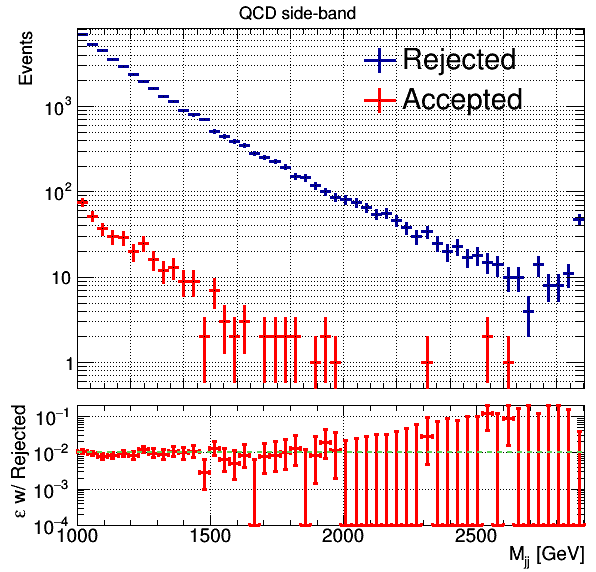

In [8]:
x = x.flatten()
binning=[50, Mjj_selection, np.quantile(x, 0.999)]

sel = getSelection(x, y)

c = plotMassSpectrum(x[sel], x[np.logical_not(sel)], 'QCD side-band')
h_a = c.h_list[1]
h_r = c.h_list[0]

# Define and test Hypotesis test

In [9]:
def HypotesisTets(h_a_bin_content, h_r_bin_content, eff, N_asymov = 10000, max_N_asymov = 1e7, show_hist=False):
    nu = eff*h_r_bin_content/(1-eff)

    probs_obs = sp.stats.poisson.pmf(h_a_bin_content.astype(np.int), nu)
    probs_obs = np.where(probs_obs < 1e-10, np.full_like(probs_obs, 1e-10), probs_obs)
    s_obs = np.sum(-np.log(probs_obs), axis=-1)
    print('S obs:', s_obs)

    N_worse = 0
    N_tot = 0
    loops = 0
    while N_worse < 25 and N_tot < max_N_asymov:
        loops += 1
        if loops > 1 and loops%10 == 0:
            print(N_tot, N_worse)
        if loops == 10:
            print('Increasing by a factor 5 the number of asymov per loop')
            N_asymov *=5
        o_asymov = np.random.poisson(nu, (N_asymov, nu.shape[0]))
        probs = sp.stats.poisson.pmf(o_asymov, nu)
        probs = np.where(probs < 1e-10, np.full_like(probs, 1e-10), probs)
        nll = -np.log(probs)
        s_asymov = np.sum(nll, axis=-1)

        N_worse += np.sum(s_asymov > s_obs)
        N_tot += N_asymov

        if max_N_asymov/N_tot < 25 and (N_worse * (max_N_asymov/N_tot) < 25):
            print('Will never have enough stat - giving up.')
            p_val = max(1, N_worse)/float(N_tot)
            return p_val

    print('Test stat reached after {} loops'.format(loops))

    p_val = max(1, N_worse)/float(N_tot)
    
    if show_hist:
        plt.figure()
        binContent, _, _ = plt.hist(s_asymov, label='Distribution assuming eff={:.1f}%'.format(100*eff))
        plt.plot([s_obs, s_obs], [0,np.max(binContent)], label='Observed')
        plt.legend(loc='best')
        plt.xlabel('Test statistic')
        plt.ylabel('Entries')

    return p_val

In [10]:
h_a_bin_content, _ = rootTH1_to_np(h_a)
h_r_bin_content, _ = rootTH1_to_np(h_r)
HypotesisTets(h_a_bin_content, h_r_bin_content, SM_eff, N_asymov=10000)

S obs: 72.35320607003878
Test stat reached after 1 loops


0.7529

# Analyze signal region

In [11]:
sample_loc = {'qcd':'qcd_dEta_signalregion_results.h5',
              'AtoZZZ':'AtoHZ_to_ZZZ_13TeV_PU40_results.h5',
              'GtoWW':'RSGraviton_WW_NARROW_13TeV_PU40_results.h5',
              'GtoBtt':'RSGraviton_tt_BROAD_13TeV_PU40_results.h5',
              'GtoNtt':'RSGraviton_tt_NARROW_13TeV_PU40_results.h5'
             }

sample_label = {'qcd':r'QCD',
                'AtoZZZ':r'$A\to ZZZ$',
                'GtoWW':r'$G\to WW$',
                'GtoBtt':r'$G_{B}\to t\bar{t}$',
                'GtoNtt':r'$G_{N}\to t\bar{t}$'
               }

sample_label_ROOT = {'qcd':'QCD',
                'AtoZZZ':'$A #rightarrow ZZZ',
                'GtoWW':'G #rightarrow WW',
                'GtoBtt':'G_{B} #rightarrow t#bar{t}',
                'GtoNtt':'G_{N} #rightarrow t#bar{t}'
               }

SM_samples = ['qcd']
BSM_samples = ['AtoZZZ', 'GtoWW', 'GtoBtt', 'GtoNtt']

sample_nGenEvts = {'qcd': 418*10000,
                   'AtoZZZ': 100*1000,
                   'GtoWW': 100*1000,
                   'GtoBtt': 96*1000,
                   'GtoNtt': 96*1000
                  }

sample_xsec = {'qcd': 8734.0 #pb
              }

### Get the data

In [12]:
data = {}
sample_eff = {}
table = PrettyTable()
table.field_names = ['Sample', 'Trg evts', 'Eff. trg [%]', 'VAE sel. evts', 'Eff VAE [%]']

for n, fname in sample_loc.iteritems():
    f = h5py.File('../data/vae_'+vae_loss+'/'+fname, 'r')
    x = np.array(f.get("results"))

    # apply the dijet mass cut
    sel_Mjj = x[:,0] > Mjj_selection
    x = x[sel_Mjj]
    dVar = computeDiscriminatingVar(x)
    sel = getSelection(x[:,0], dVar)
    x = np.column_stack((x, dVar, sel))
    
    sample_eff[n] = float(x.shape[0])/sample_nGenEvts[n]
    
    dt = [(str(s), '<f4') for s in list(f.get("labels")) + ['dVar']]
    dt += [('sel', '?')]
    data[n] = np.array(list(zip(*x.T)), dtype=dt)
    
    eff = '{:.2f}'.format(100*np.sum(data[n]['sel'])/float(data[n]['sel'].shape[0]))
    table.add_row([n, data[n]['sel'].shape[0], '{:.1f}'.format(100*sample_eff[n]), np.sum(data[n]['sel']), eff])
    
print(table)

+--------+----------+--------------+---------------+-------------+
| Sample | Trg evts | Eff. trg [%] | VAE sel. evts | Eff VAE [%] |
+--------+----------+--------------+---------------+-------------+
| GtoBtt |  65082   |     67.8     |     11039     |    16.96    |
| GtoWW  |  52408   |     52.4     |     11187     |    21.35    |
| GtoNtt |  63748   |     66.4     |     10915     |    17.12    |
| AtoZZZ |  63490   |     63.5     |     12113     |    19.08    |
|  qcd   |  86911   |     2.1      |      805      |     0.93    |
+--------+----------+--------------+---------------+-------------+


### Define utilitities

In [13]:
def plotMassSpectrum_wSig(h_r, h_a, h_a_sig, name_BSM, lumi_text, p_val):
    h_r.GetYaxis().SetRangeUser(0.5, 1.2*h_r.GetMaximum())
    h_r.SetStats(0)
    h_r.Sumw2()
    h_r.SetLineWidth(2)
    
    h_a.SetLineColor(2)
    h_a.SetStats(0)
    h_a.Sumw2()
    h_a.SetLineWidth(2)
    
    h_a_sig.SetFillStyle(3001)
    h_a_sig.SetFillColor(8)
    h_a_sig.SetLineWidth(0)

    c = make_effiency_plot([h_r, h_a], ratio_bounds=[1e-3, None], draw_opt = 'E')
    c.pad1.SetLogy()
    c.pad1.cd()
    h_a_sig.Draw('SAME')
    c.leg.AddEntry(h_a_sig, 'Acc. '+sample_label_ROOT[name_BSM], 'f')
    
    latex = rt.TLatex()
    latex.SetNDC()
    latex.SetTextSize(0.04)
    latex.SetTextAlign(31)
    t = c.pad1.GetTopMargin()
    r = c.pad1.GetRightMargin()
    latex.DrawLatex(1-r, 1-0.85*t, lumi_text)

    c.pad2.SetLogy()
    c.pad2.cd()
    c.ln = rt.TLine(h_r.GetXaxis().GetXmin(), SM_eff, h_r.GetXaxis().GetXmax(), SM_eff)
    c.ln.SetLineWidth(2)
    c.ln.SetLineStyle(7)
    c.ln.SetLineColor(6)
    c.ln.DrawLine(h_r.GetXaxis().GetXmin(), SM_eff, h_r.GetXaxis().GetXmax(), SM_eff)
    
    latex.SetTextSize(0.1)
    latex.SetTextAlign(13)
    l = c.pad2.GetLeftMargin()
    t = c.pad2.GetTopMargin()
    latex.DrawLatex(l*1.1, 1-2*t, 'p-value: {:.1f}%'.format(100*p_val))

    c.Draw()
    return c

## Find the p-value as a function of xsec

In [14]:
lumi = 100 #pb^-1

N_asymov = 10000
# N_asymov = int(1 / (1 - erf(5.5/np.sqrt(2))))
N_exp_per_xsec = 50

In [15]:
dic_p_val = {}
rt.gROOT.SetBatch(True)



AtoZZZ
xsec BSM 1.0e-01 pb
Experiment: 0
S obs: 55.413565227500136
Test stat reached after 1 loops
Experiment: 1
S obs: 72.7632289684159
Test stat reached after 1 loops
Experiment: 2
S obs: 72.88080453144833
Test stat reached after 1 loops
Experiment: 3
S obs: 68.41455937177045
Test stat reached after 1 loops
Experiment: 4
S obs: 64.12961155481747
Test stat reached after 1 loops
Experiment: 5
S obs: 65.51421672010177
Test stat reached after 1 loops
Experiment: 6
S obs: 78.05679583247661
Test stat reached after 3 loops
Experiment: 7
S obs: 60.39697482405152
Test stat reached after 1 loops
Experiment: 8
S obs: 56.7968573810906
Test stat reached after 1 loops
Experiment: 9
S obs: 60.87810315358162
Test stat reached after 1 loops
Experiment: 10
S obs: 65.18670327095967
Test stat reached after 1 loops
Experiment: 11
S obs: 65.18004286823597
Test stat reached after 1 loops
Experiment: 12
S obs: 56.578593979667865
Test stat reached after 1 loops
Experiment: 13
S obs: 61.463933292182816
Test

Test stat reached after 1 loops
Experiment: 14
S obs: 98.10912766702448
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 15
S obs: 77.84761096854466
Test stat reached after 4 loops
Experiment: 16
S obs: 73.36178628659246
Test stat reached after 1 loops
Experiment: 17
S obs: 68.41370104527915
Test stat reached after 1 loops
Experiment: 18
S obs: 65.80971027017176
Test stat reached after 1 loops
Experiment: 19
S obs: 77.6222706339812
Test stat reached after 2 loops
Experiment: 20
S obs: 62.22558587175779
Test stat reached after 1 loops
Experiment: 21
S obs: 63.97810413325387
Test stat reached after 1 loops
Experiment: 22
S obs: 64.83108636248495
Test stat reached after 1 loops
Experiment: 23
S obs: 74.69867767191734
Test stat reached after 1 loops
Experiment: 24
S obs: 64.42382010309683
Test stat reached after 1 loops
Experiment: 25
S obs: 66.8518394972644
Test stat reached after 1 loops
Experiment: 26
S obs: 75.052440283

Will never have enough stat - giving up.
Experiment: 7
S obs: 97.50028441017272
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 8
S obs: 104.69443443042599
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 9
S obs: 123.20487831782212
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 10
S obs: 109.83448408451672
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 11
S obs: 78.58207263163548
Test stat reached after 2 loops
Experiment: 12
S obs: 126.29440208313002
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 13
S obs: 95.04848784111759
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 14
S obs: 

90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 17
S obs: 134.63802835214003
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 18
S obs: 140.66072011388894
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 19
S obs: 153.05977171039746
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 20
S obs: 137.62539772342416
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 21
S obs: 161.57712456782417
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 22
S obs: 115.05873780453226
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 23
S obs: 158.

90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 24
S obs: 257.5918126143399
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 25
S obs: 253.75547434758218
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 26
S obs: 276.5635129027216
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 27
S obs: 245.11904411596302
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 28
S obs: 282.0195582204011
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 29
S obs: 276.60959469038363
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 30
S obs: 297.250

Test stat reached after 1 loops
Experiment: 11
S obs: 74.28108479424593
Test stat reached after 1 loops
Experiment: 12
S obs: 66.55390863026891
Test stat reached after 1 loops
Experiment: 13
S obs: 62.30679593309214
Test stat reached after 1 loops
Experiment: 14
S obs: 55.8762780361068
Test stat reached after 1 loops
Experiment: 15
S obs: 70.78452753116133
Test stat reached after 1 loops
Experiment: 16
S obs: 62.08537645757303
Test stat reached after 1 loops
Experiment: 17
S obs: 73.57904266819553
Test stat reached after 1 loops
Experiment: 18
S obs: 52.817888271345694
Test stat reached after 1 loops
Experiment: 19
S obs: 65.70795920458309
Test stat reached after 1 loops
Experiment: 20
S obs: 65.31734937006154
Test stat reached after 1 loops
Experiment: 21
S obs: 64.33817948454019
Test stat reached after 1 loops
Experiment: 22
S obs: 60.262772188338296
Test stat reached after 1 loops
Experiment: 23
S obs: 63.32135134015355
Test stat reached after 1 loops
Experiment: 24
S obs: 59.464485

90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 23
S obs: 61.52623270725897
Test stat reached after 1 loops
Experiment: 24
S obs: 56.55923593609021
Test stat reached after 1 loops
Experiment: 25
S obs: 73.41066637290419
Test stat reached after 1 loops
Experiment: 26
S obs: 66.28297356232939
Test stat reached after 1 loops
Experiment: 27
S obs: 62.46046202865696
Test stat reached after 1 loops
Experiment: 28
S obs: 62.86439682663432
Test stat reached after 1 loops
Experiment: 29
S obs: 67.96720596549245
Test stat reached after 1 loops
Experiment: 30
S obs: 81.69618388329935
90000 15
Increasing by a factor 5 the number of asymov per loop
Test stat reached after 10 loops
Experiment: 31
S obs: 64.75581966680674
Test stat reached after 1 loops
Experiment: 32
S obs: 62.64321939011217
Test stat reached after 1 loops
Experiment: 33
S obs: 76.24606657251874
Test stat reached after 1 loops
Experiment: 34
S obs: 54.63960083259864

Will never have enough stat - giving up.
Experiment: 19
S obs: 79.59232753231727
Test stat reached after 2 loops
Experiment: 20
S obs: 81.34028518619077
Test stat reached after 3 loops
Experiment: 21
S obs: 88.4191802890157
90000 3
Increasing by a factor 5 the number of asymov per loop
590000 16
Test stat reached after 28 loops
Experiment: 22
S obs: 79.92934666997493
Test stat reached after 2 loops
Experiment: 23
S obs: 89.63214908773935
90000 4
Increasing by a factor 5 the number of asymov per loop
590000 13
1090000 19
Test stat reached after 34 loops
Experiment: 24
S obs: 101.69468650434519
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 25
S obs: 96.24642838891887
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 26
S obs: 78.15764101204161
Test stat reached after 1 loops
Experiment: 27
S obs: 74.24982077948555
Test stat reached after 1 loops
Experime

90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 31
S obs: 158.51874649221406
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 32
S obs: 135.95023305367954
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 33
S obs: 130.48745307796133
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 34
S obs: 141.64782627621878
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 35
S obs: 139.96105811957406
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 36
S obs: 166.10339485849283
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 37
S obs: 173.

Test stat reached after 1 loops
Experiment: 21
S obs: 51.59116712874209
Test stat reached after 1 loops
Experiment: 22
S obs: 53.576513227127734
Test stat reached after 1 loops
Experiment: 23
S obs: 62.53116740834807
Test stat reached after 1 loops
Experiment: 24
S obs: 65.61453089963194
Test stat reached after 1 loops
Experiment: 25
S obs: 90.92405450751762
90000 0
Increasing by a factor 5 the number of asymov per loop
590000 2
Will never have enough stat - giving up.
Experiment: 26
S obs: 65.81774158965347
Test stat reached after 1 loops
Experiment: 27
S obs: 61.556402496772506
Test stat reached after 1 loops
Experiment: 28
S obs: 72.63441851410919
Test stat reached after 1 loops
Experiment: 29
S obs: 82.30399769092911
90000 12
Increasing by a factor 5 the number of asymov per loop
Test stat reached after 12 loops
Experiment: 30
S obs: 70.14417862609848
Test stat reached after 1 loops
Experiment: 31
S obs: 68.46507309638432
Test stat reached after 1 loops
Experiment: 32
S obs: 84.462

Test stat reached after 10 loops
Experiment: 22
S obs: 68.4468358179259
Test stat reached after 1 loops
Experiment: 23
S obs: 71.49580353467144
Test stat reached after 1 loops
Experiment: 24
S obs: 71.70960498255195
Test stat reached after 1 loops
Experiment: 25
S obs: 72.95908089544878
Test stat reached after 1 loops
Experiment: 26
S obs: 66.89143723054363
Test stat reached after 1 loops
Experiment: 27
S obs: 70.88614316725707
Test stat reached after 1 loops
Experiment: 28
S obs: 88.30420136507216
90000 1
Increasing by a factor 5 the number of asymov per loop
590000 4
1090000 8
1590000 11
2090000 20
2590000 24
Test stat reached after 61 loops
Experiment: 29
S obs: 81.38888779345383
Test stat reached after 8 loops
Experiment: 30
S obs: 69.16353540184036
Test stat reached after 1 loops
Experiment: 31
S obs: 87.17774646121633
90000 0
Increasing by a factor 5 the number of asymov per loop
590000 6
1090000 17
Test stat reached after 32 loops
Experiment: 32
S obs: 84.72057725147063
90000 12

90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 38
S obs: 86.33080330715104
90000 3
Increasing by a factor 5 the number of asymov per loop
590000 23
Test stat reached after 20 loops
Experiment: 39
S obs: 100.95094726689814
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 40
S obs: 93.92799331330063
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 41
S obs: 120.6791399362149
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 42
S obs: 100.3820967943028
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 43
S obs: 116.61176895950993
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 44
S obs: 121.85

Will never have enough stat - giving up.
Experiment: 45
S obs: 191.47963499794574
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 46
S obs: 137.64406220356523
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 47
S obs: 146.17506096614323
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 48
S obs: 136.90217532855507
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 49
S obs: 175.0376417421894
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
xsec BSM 1.0e+01 pb
Experiment: 0
S obs: 256.02548820696984
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 1
S obs: 300.46348466306165
90000 0
Increasing by a factor 

Test stat reached after 1 loops
Experiment: 5
S obs: 57.75298374541839
Test stat reached after 1 loops
Experiment: 6
S obs: 63.89496214494365
Test stat reached after 1 loops
Experiment: 7
S obs: 60.518024028232354
Test stat reached after 1 loops
Experiment: 8
S obs: 58.90834347220943
Test stat reached after 1 loops
Experiment: 9
S obs: 73.83478453083502
Test stat reached after 1 loops
Experiment: 10
S obs: 62.60214759152969
Test stat reached after 1 loops
Experiment: 11
S obs: 78.58592838996691
Test stat reached after 5 loops
Experiment: 12
S obs: 62.95409984115337
Test stat reached after 1 loops
Experiment: 13
S obs: 55.94001874017534
Test stat reached after 1 loops
Experiment: 14
S obs: 56.183427396362724
Test stat reached after 1 loops
Experiment: 15
S obs: 55.65816025805537
Test stat reached after 1 loops
Experiment: 16
S obs: 59.984362285559904
Test stat reached after 1 loops
Experiment: 17
S obs: 54.4684248176049
Test stat reached after 1 loops
Experiment: 18
S obs: 59.2312509712

90000 9
Increasing by a factor 5 the number of asymov per loop
Test stat reached after 11 loops
Experiment: 13
S obs: 88.12644496826714
90000 2
Increasing by a factor 5 the number of asymov per loop
590000 4
1090000 8
1590000 14
2090000 18
2590000 19
Test stat reached after 69 loops
Experiment: 14
S obs: 77.86157482588042
Test stat reached after 3 loops
Experiment: 15
S obs: 71.81486155398258
Test stat reached after 1 loops
Experiment: 16
S obs: 63.876749077923584
Test stat reached after 1 loops
Experiment: 17
S obs: 74.05417502496256
Test stat reached after 1 loops
Experiment: 18
S obs: 72.44872737436555
Test stat reached after 1 loops
Experiment: 19
S obs: 66.42416783026198
Test stat reached after 1 loops
Experiment: 20
S obs: 74.85432814838374
Test stat reached after 1 loops
Experiment: 21
S obs: 64.72362471120893
Test stat reached after 1 loops
Experiment: 22
S obs: 62.81718787022552
Test stat reached after 1 loops
Experiment: 23
S obs: 101.05720026427944
90000 0
Increasing by a fa

Will never have enough stat - giving up.
xsec BSM 2.2e+00 pb
Experiment: 0
S obs: 108.7347302542778
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 1
S obs: 121.52168654762725
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 2
S obs: 112.53289384781358
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 3
S obs: 122.245921510167
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 4
S obs: 84.16725167849131
Test stat reached after 9 loops
Experiment: 5
S obs: 95.2427681084264
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 6
S obs: 98.31055326334938
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment

90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 6
S obs: 125.55676393588443
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 7
S obs: 133.4361484102547
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 8
S obs: 135.47689084878928
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 9
S obs: 155.00637610653587
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 10
S obs: 159.09974768513823
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 11
S obs: 156.31487762821564
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 12
S obs: 129.09708

90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 13
S obs: 272.32069277250116
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 14
S obs: 269.42752894759735
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 15
S obs: 298.3043913505955
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 16
S obs: 262.19974600148134
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 17
S obs: 292.2586391617554
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 18
S obs: 291.1025577192402
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 19
S obs: 279.037

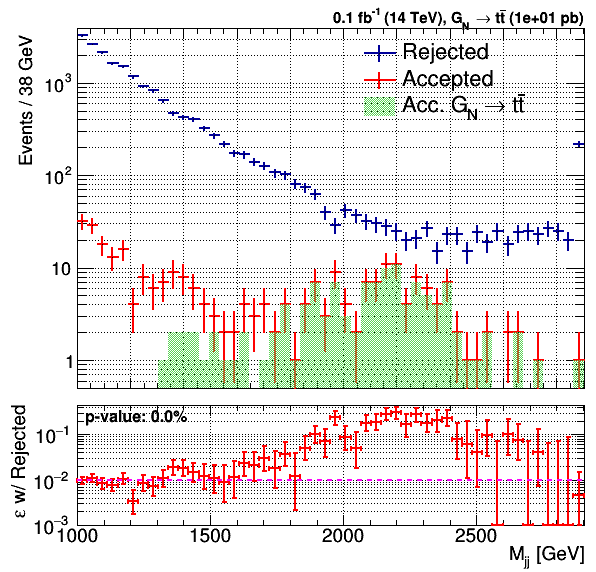

In [16]:
for name_BSM in BSM_samples:
    print('\n\n'+name_BSM)
    dic_p_val[name_BSM] = []
    for xsec_BSM in np.logspace(-1, 1, 7): 
        print('xsec BSM {:.1e} pb'.format(xsec_BSM))
        lumi_text = '{:.1f} fb^{{-1}} (14 TeV), '.format(1e-3*lumi) + sample_label_ROOT[name_BSM] + ' ({:.2} pb)'.format(xsec_BSM)

        p_val_test = []
        for i_exp in range(N_exp_per_xsec):
            print('Experiment:', i_exp)
            d_obs = np.zeros((0,2))

            sample_xsec[name_BSM] = xsec_BSM
            for n in SM_samples + [name_BSM]:
                nExpEvts = lumi*sample_xsec[n]*sample_eff[n]
                nEvts = np.random.poisson(nExpEvts)
                if data[n]['mJJ'].shape[0] < nEvts:
                    print('[WARNING] ' + n + ' re-use factor = {:.2f}'.format(float(nEvts)/data[n]['mJJ'].shape[0]))
                evtsIdx = np.random.randint(0, data[n]['mJJ'].shape[0], size=(nEvts,))

                d_aux = np.column_stack((data[n]['mJJ'][evtsIdx], data[n]['sel'][evtsIdx]))
                d_obs = np.concatenate((d_obs, d_aux))

            h_a = create_TH1D(d_obs[:, 0][d_obs[:,1].astype(np.bool)], 
                                 name='h_acc', title='Accepted',
                                 binning=binning,
                                 opt='overflow'
                                )

            h_r = create_TH1D(d_obs[:, 0][np.logical_not(d_obs[:,1]).astype(np.bool)], 
                                 name='h_rej', title='Rejected',
                                 axis_title=['M_{jj} [GeV]', ''],
                                 binning=binning,
                                 opt='overflow'
                                )
            h_r.SetYTitle('Events / {:.0f} GeV'.format(h_r.GetBinWidth(1)))

            h_a_bin_content, _ = rootTH1_to_np(h_a)
            h_r_bin_content, _ = rootTH1_to_np(h_r)
            p_val = HypotesisTets(h_a_bin_content, h_r_bin_content, SM_eff, N_asymov = N_asymov, show_hist=False)
            p_val_test.append(p_val)

            if i_exp > 3 and np.max(p_val_test) == 0:
                break

            if i_exp == 0:
                h_a_sig = create_TH1D(d_obs[-nEvts-1:, 0][d_obs[-nEvts-1:, 1].astype(np.bool)], 
                                     name='h_acc', title='Accepted',
                                     binning=binning,
                                     opt='overflow'
                                    )
                c = plotMassSpectrum_wSig(h_r, h_a, h_a_sig, name_BSM, lumi_text, p_val)
                fig_name = '../fig/ModelIndependentAnalysis/massSpectrum/'
                fig_name += name_BSM + '{:1.2e}'.format(xsec_BSM) + 'pb' + '_L' + str(lumi) + 'pb-1_wEff'
                c.SaveAs(fig_name + '.png')

        aux = [xsec_BSM] + list(np.percentile(p_val_test, [2.5, 16, 50, 84, 97.5]))
        dic_p_val[name_BSM].append(aux)

# Make the p-value plot

In [17]:
sample_col = {
              'AtoZZZ':'r',
              'GtoWW':'b',
              'GtoBtt':'g',
              'GtoNtt':'c'
             }

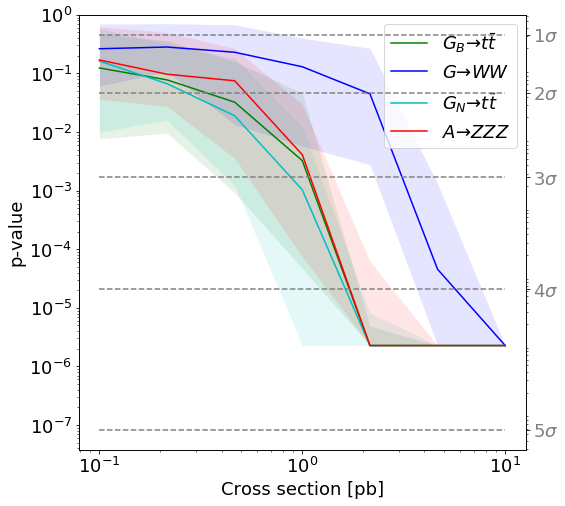

In [20]:
matplotlib.rcParams.update({'font.size': 18})
fig, ax1 = plt.subplots(figsize=(8,8))

for n, val_aux in dic_p_val.iteritems():
    val_aux = np.array(val_aux)
    x_sec = val_aux[:, 0]
    quant = val_aux[:, 1:]
    
    ax1.plot(x_sec, quant[:, 2], color=sample_col[n], label=sample_label[n])
    ax1.fill_between(x_sec, quant[:, 1], quant[:, 3], color=sample_col[n], alpha = 0.1, lw=0)
#     ax1.fill_between(x_sec, quant[:, 0], quant[:, 4], color=sample_col[n], alpha = 0.1, lw=0)
    
    
plt.xscale('log')
plt.xlabel('Cross section [pb]')
plt.yscale('log')
plt.ylabel('p-value')
plt.ylim(1 - erf(5.5/np.sqrt(2)), 1)
plt.legend(loc='upper right')
ax2 = ax1.twinx()
for i in range(1, 6):
    p = 1 - erf(i/np.sqrt(2))
    ax2.plot([x_sec[0], x_sec[-1]], 2*[p], '--', color='grey')
plt.yscale('log')
ax2.set_yticks(1 - erf(np.arange(1,6)/np.sqrt(2)))
ax2.set_yticklabels(['{}$\sigma$'.format(i) for i in range(1,6)])
ax2.tick_params(axis='y', labelcolor='grey')

fig.savefig('../fig/ModelIndependentAnalysis/' + 'pValueScan_L' + str(lumi) + 'pb-1.png', bbox_inches='tight')